In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

load dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


dataset visualization

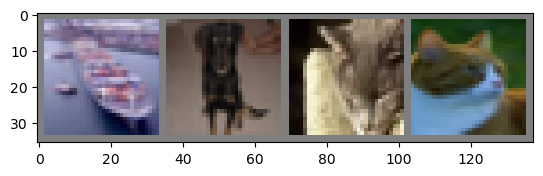

 ship   dog   cat   cat


In [5]:
import matplotlib.pyplot as plt
import numpy as np
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(trainloader))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Build a DNN

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

setup optimizer and loss function

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train a network

In [9]:
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 1.404
[1,  4000] loss: 1.390
[1,  6000] loss: 1.372
[1,  8000] loss: 1.342
[1, 10000] loss: 1.320
[1, 12000] loss: 1.301
Finished Training


save and load the network

In [10]:
# save the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# load the model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

try

In [11]:

images, labels = next(iter(testloader))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:   frog  ship   car plane


test the model

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


transfer the PyTorch model to mlmodel

In [13]:
import coremltools

example_input = torch.rand(1, 3, 32, 32) 

net.eval()

# Trace the model with random data.
traced_net = torch.jit.trace(net, example_input)
out = traced_net(example_input)

model = coremltools.convert(
    traced_net,
    inputs=[coremltools.TensorType(shape=example_input.shape)]
 )
model.save("my_net.mlmodel")

scikit-learn version 1.2.0 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.
Torch version 2.1.0 has not been tested with coremltools. You may run into unexpected errors. Torch 2.0.0 is the most recent version that has been tested.
Running MIL default pipeline:   0%|          | 0/56 [00:00<?, ? passes/s]/Users/jingweixu/opt/anaconda3/lib/python3.10/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:234: UserWarning: Input, 'x.1', of the source model, has been renamed to 'x_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
/Users/jingweixu/opt/anaconda3/lib/python3.10/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:262: UserWarning: Output, '63', of the source model, has been renamed to 'var_63' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 43/43 [00:00<00:00, 1318.97 ops/